In [1]:
import os

In [3]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

In [4]:
from dotenv import load_dotenv

In [5]:
load_dotenv()

False

In [7]:
from langchain_google_genai import ChatGoogleGenerativeAI

In [8]:
model = ChatGoogleGenerativeAI(model="gemini-pro", temperature=0.7,convert_system_message_to_human=True)

ValidationError: 1 validation error for ChatGoogleGenerativeAI
__root__
  Did not find google_api_key, please add an environment variable `GOOGLE_API_KEY` which contains it, or pass `google_api_key` as a named parameter. (type=value_error)

In [9]:
from langchain_core.tools import tool

In [10]:
@tool
def search(query: str):
    """Call to surf the web."""
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."


In [11]:
tools = [search]

In [12]:
tool_node = ToolNode(tools)

In [13]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


In [14]:
from typing import Literal

In [15]:
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END

In [16]:
workflow=StateGraph(MessagesState)

In [17]:
workflow.add_node("agent",call_model)

In [18]:
workflow.add_node("tools",call_model)

In [19]:
# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

In [20]:
workflow.set_entry_point("agent")

In [21]:
# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", 'agent')

In [22]:
checkpointer = MemorySaver()

In [23]:
app=workflow.compile(checkpointer=checkpointer)

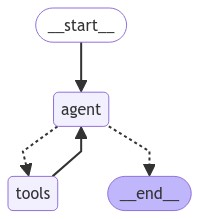

In [24]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [25]:
from langchain_core.messages import HumanMessage

In [1]:
# Use the Runnable
final_state = app.invoke({"messages": [HumanMessage(content="what is the tomorrow weather in sf?")]},config={"configurable": {"thread_id": 42}})

NameError: name 'app' is not defined

In [29]:
final_state["messages"][-1].content

NameError: name 'final_state' is not defined

In [30]:

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in app.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)